In [56]:
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport
import chardet
import glob
import os
import shutil
import seaborn as sns
import matplotlib.pyplot as plt
import unicodedata
import sys
import cfunits

# import custom modules
sys.path.append('../scripts')
import funcs

---
---
# Table of contents
* [1. Load source data](#load-data)
    * [1.1. Preview headers](#preview-headers)  
* [2. Prepare data headers](#prep-headers)
    * [2.1. Preview headers, descriptions, and units](#view-headers)
    * [2.2. Clean headers, descriptions, and units](#clean-headers)
        * [2.2.1. Units (multi-header index 2)](#units)
        * [2.2.2. Descriptions (multi-header index 1)](#descriptions)
        * [2.2.3. Variables (multi-header index 0)](#variables)
        * [2.2.4. Data values](#data-vals)
* [3. Standardize data headers](#standardizing-steps)
    * [3.1. Copy of filename_headers to filename_headers_lookup](#copy)
    * [3.2. Assign lookup table header names](#assign)
    * [3.3. Use ESS-Dive leaf-gas-exchange standards to create lookup table](#multiheader-standards)
    * [3.4. Load the lookup table](#complete-lookup)
    * [3.5. Use the lookup table to standardize headers](#standardize)
* [4. Data quality control](#qc)
    * [4.1. Strings](#strings)
    * [4.2. Measurememt device](#device)
    * [4.3. Season](#season)
    * [4.4. Plant height](#height)
    * [4.5. Datetimes](#datetimes)
    * [4.6. Species names](#species)
    * [4.7. Create species lookup table](#species-lookup)
    * [4.8. Fill in species lookup table](#fill-species-lookup)
        * [4.8.1. Format headers](#species-lookup-headers)
        * [4.8.2. Merge lookup table with data](#merge)
        * [4.8.3. Drop extra columns](#drop)
* [5. Data unit conversion](#unit-conversion)
    * [5.1. Visualize and confirm unit conversions](#confirm-conversion)
    * [5.2. Drop out-of-range (oor) values](#oor)

---
---
## 1. Load the data <a class="anchor" id="load-data"></a>
NOTE: If certain fancy characters aren't used in a file, an encoder will pick it up as us/ascii even if I've explicitly encoded it as utf-8-sig, and that's fine. UTF-8-SIG just ensures that the .csv is read properly in Excel on a Mac AND a windows computer.

In [98]:
filename = 'anderegg_2018'
data_dir_path = f'../data/input/{filename}'

In [99]:
# # ensure encoding of individual ACI curve files
# for f in os.listdir(data_dir_path):
#     if f.endswith(".csv"):
#         original_file_path = os.path.join(data_dir_path, f)
#         funcs.convert_to_utf8sig(original_file_path)

In [132]:
# data paths
utf8_d1_path = f'../data/input/{filename}/anderegg_2018.csv'
utf8_d2_path = f'../data/input/{filename}/anderegg_2018_supp1.csv'
utf8_metadata_path = f'../data/input/{filename}/anderegg_2018_supp2.csv'

# read the data
d1 = pd.read_csv(utf8_d1_path, index_col=0, na_values=[-9999, '-9999', '-9999.0', 'none', 'None', None])
d2 = pd.read_csv(utf8_d2_path, na_values=[-9999, '-9999', '-9999.0', 'none', 'None', None])

# ensure readable encoding of metadata files (01, 02)
metadata = pd.read_csv(utf8_metadata_path)

In [133]:
# join the d1 and d2 by species name (but of course the syntax are different)
# clean up syntax in d1
d1['Species'] = d1['Species'].str.lower().str.strip()
replacements = {'a. bidwillii':'austromyrtus bidwillii',
                'a. excelsa':'alphitonia excelsa',
                'annha':'annona hayesii',
                'astgr':'astronium graveolens',
                'b. australe':'brachychiton australis',
                'bursi':'bursera simaruba',
                'c. gillivraei':'cochlospermum gillivraei',
                'cavpl':'cavanillesia platanifolia',
                'cojru':'cojoba rufescens',
                'genam':'genipa americana',
                'quercus ilex_stpaul_les mages':'quercus ilex',
                'quercus ilex_stpaul_puechabon':'quercus ilex',
                'quercus ilex_stpaul_vic la gardiole':'quercus ilex',
                'eucualypus globulus':'eucalyptus globulus',
                'populus balsimifora':'populus balsamifera'
                }
d1['Species'] = d1['Species'].replace(replacements)

In [134]:
# clean up syntax in d2
d2['Species name'] = d2['Species name'].str.lower().str.strip()
d2['Species name'] = d2['Species name'].replace({'populus balsamifora':'populus balsamifera'})

In [135]:
data = d1.merge(d2, left_on='Species', right_on='Species name', how='left')

---
### 1.1. Preview the data and metadata headers <a class="anchor" id="preview-headers"></a>
If there are no metadata provided, you must create a metadata .csv based on the headers in the data

In [136]:
data.columns

Index(['Pathway', 'Type', 'Plantform', 'Leafspan', 'Tregion', 'Wregion',
       'Wregion2', 'opt', 'Date', 'Time', 'Datacontrib', 'Species', 'Funtype',
       'fitgroup', 'Location', 'RH', 'Tair', 'Tleaf', 'CO2S', 'PARin', 'Patm',
       'BLCond', 'Trmmol', 'SWC', 'SWP', 'latitude', 'longitude',
       'Totalheight', 'LAI', 'sampleheight', 'canopyposition', 'LWP',
       'LWPpredawn', 'Instrument', 'Season', 'GrowthCa', 'GrowthTair',
       'Growthcond', 'Treatment', 'OriginalFile', 'Comments', 'Reference_x',
       'LightSource', 'Cond', 'Photo', 'VPD', 'Ci', 'Species name', 'Biome',
       'Wb c', 'Wb d', 'N', 'Vcmax', 'Reference_y'],
      dtype='object')

In [137]:
# this is how the metadata file should be structured before reading it: variable, description, units
# this may have to be created or edited manually before reading it here
metadata = metadata.rename(columns={'Symbol':'variable', 
                                    'Units':'unit', 
                                    'Definition':'description'})
metadata = metadata.drop(columns=['Status'])
metadata

,variable,description,unit
0,gs,Stomatal conductance,mol m-2 s-1
1,C,Carbon gain as the balance of net assimilation...,mmol m-2 s-1
2,An,Net assimilation (photosynthesis minus respira...,mmol m-2 s-1
3,Θ,Carbon costs of the risk of a given water pote...,mmol m-2 s-1
4,Θ,Marginal carbon costs of the risk of a given w...,mmol m-2 s-1 MPa-1
5,NaN,NaN,NaN
6,ψL,Leaf water potential,MPa
7,ψS,Soil water potential,MPa
8,ψ,Tissue water potential,MPa
9,K,Hydraulic conductance to water,mmol m-2 s-1 MPa-1


---
---
## 2. Prepare data headers <a class="anchor" id="prep-headers"></a>
Add variable/description/units to as a 3-row multi-header

In [138]:
# merge metadata with data column names
columns_df = pd.DataFrame({'variable': data.columns})
matched_metadata = columns_df.merge(metadata, on='variable', how='left')

# check for unmatched variables
unmatched = matched_metadata[matched_metadata['description'].isnull()]
if not unmatched.empty:
    print("Warning: Some columns in the data file do not match the metadata:")
    print(unmatched)

# note, the metadata they provided isn't great

          variable description unit
0          Pathway         NaN  NaN
1             Type         NaN  NaN
2        Plantform         NaN  NaN
3         Leafspan         NaN  NaN
4          Tregion         NaN  NaN
5          Wregion         NaN  NaN
6         Wregion2         NaN  NaN
7              opt         NaN  NaN
8             Date         NaN  NaN
9             Time         NaN  NaN
10     Datacontrib         NaN  NaN
11         Species         NaN  NaN
12         Funtype         NaN  NaN
13        fitgroup         NaN  NaN
14        Location         NaN  NaN
15              RH         NaN  NaN
16            Tair         NaN  NaN
17           Tleaf         NaN  NaN
18            CO2S         NaN  NaN
19           PARin         NaN  NaN
20            Patm         NaN  NaN
21          BLCond         NaN  NaN
22          Trmmol         NaN  NaN
23             SWC         NaN  NaN
24             SWP         NaN  NaN
25        latitude         NaN  NaN
26       longitude         N

In [139]:
# drop unmatched variables
matched_metadata = matched_metadata.dropna(subset=['variable'])
data = data[matched_metadata['variable'].tolist()]

# create the description and unit rows
description_row = matched_metadata['description'].tolist()
unit_row = matched_metadata['unit'].tolist()
data_with_metadata = pd.concat(
    [pd.DataFrame([description_row, unit_row], columns=data.columns), data],
    ignore_index=True)

# Set the multi-index
data_with_metadata.columns = pd.MultiIndex.from_arrays(
    [data.columns, description_row, unit_row],
    names=['variable', 'description', 'unit'])
data_with_metadata = data_with_metadata.iloc[2:]

In [140]:
# replace data dataframe with the one with metadata
data = data_with_metadata.iloc[2:].copy()
data

variable,Pathway,Type,Plantform,Leafspan,Tregion,Wregion,Wregion2,opt,Date,Time,...,Photo,VPD,Ci,Species name,Biome,Wb c,Wb d,N,Vcmax,Reference_y
description,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Internal leaf CO2 concentration,NaN,NaN,NaN,NaN,NaN,Maximum rate of carboxylation at 25 C,NaN
unit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,ppm,NaN,NaN,NaN,NaN,NaN,mmol m-2 s-1,NaN
4,C3,angiosperm,tree,evergreen,temperate,humid,0.977,opt,27/11/2009,8:52:30,...,14.126326,1.310000,251.358395,quercus ilex,BET,4.2,1.4,110.0,V,St. Paul et al. 2012
5,C3,angiosperm,tree,evergreen,temperate,humid,0.977,opt,21/06/2009,11:12:15,...,6.721385,1.910000,215.880258,quercus ilex,BET,4.2,1.4,110.0,V,St. Paul et al. 2012
6,C3,angiosperm,tree,evergreen,temperate,humid,0.977,opt,20/07/2009,11:30:24,...,3.526875,4.370000,236.524749,quercus ilex,BET,4.2,1.4,110.0,V,St. Paul et al. 2012
7,C3,angiosperm,tree,evergreen,temperate,humid,0.977,opt,28/04/2009,12:03:04,...,12.561820,2.260000,189.810753,quercus ilex,BET,4.2,1.4,110.0,V,St. Paul et al. 2012
8,C3,angiosperm,tree,evergreen,temperate,humid,0.977,opt,27/11/2009,13:50:53,...,5.885032,1.440000,245.146039,quercus ilex,BET,4.2,1.4,110.0,V,St. Paul et al. 2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3695,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20.327120,2.135457,227.486152,eucalyptus globulus,BET,1.6,1.4,73.0,81.7,Hernandez et al. 2016
3696,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.286368,2.480808,191.230231,eucalyptus globulus,BET,1.6,1.4,73.0,81.7,Hernandez et al. 2016


---
### 2.1. Preview headers, descriptions, and units <a class="anchor" id="view-headers"></a>

In [141]:
data.columns.get_level_values(0)

Index(['Pathway', 'Type', 'Plantform', 'Leafspan', 'Tregion', 'Wregion',
       'Wregion2', 'opt', 'Date', 'Time', 'Datacontrib', 'Species', 'Funtype',
       'fitgroup', 'Location', 'RH', 'Tair', 'Tleaf', 'CO2S', 'PARin', 'Patm',
       'BLCond', 'Trmmol', 'SWC', 'SWP', 'latitude', 'longitude',
       'Totalheight', 'LAI', 'sampleheight', 'canopyposition', 'LWP',
       'LWPpredawn', 'Instrument', 'Season', 'GrowthCa', 'GrowthTair',
       'Growthcond', 'Treatment', 'OriginalFile', 'Comments', 'Reference_x',
       'LightSource', 'Cond', 'Photo', 'VPD', 'Ci', 'Species name', 'Biome',
       'Wb c', 'Wb d', 'N', 'Vcmax', 'Reference_y'],
      dtype='object', name='variable')

In [142]:
data.columns.get_level_values(1).unique()

Index([nan, 'Internal leaf CO2 concentration',
       'Maximum rate of carboxylation at 25 C'],
      dtype='object', name='description')

In [143]:
data.columns.get_level_values(2).unique()

Index([nan, 'ppm', 'mmol m-2 s-1'], dtype='object', name='unit')

---
### 2.2. Clean headers, descriptions, and units <a class="anchor" id="clean-headers"></a>

#### 2.2.1. Units (multi-header index 2) <a class="anchor" id="units"></a>
Some examples of correct unit formats:
* mmol m-2 s-1
* m-2 s-1
* 1 (for unitless values or categorical data)
* degree_C
* degree (for decimal degrees)

In [144]:
# clean units using local modules in funcs.py: funcs.clean_values()
values = data.columns.get_level_values(2)
cleaned_l2_values = funcs.clean_values(values)

# replace unclean units with cleaned units
data.columns = pd.MultiIndex.from_arrays([
    data.columns.get_level_values(0),
    data.columns.get_level_values(1),
    cleaned_l2_values
])

In [145]:
data.columns.get_level_values(2).unique()

Index([nan, 'ppm', 'mmol m-2 s-1'], dtype='object', name='unit')

In [146]:
replacement_l2_vals = {np.nan:1}

In [147]:
# standardize level-2 (unit) values
# Get the levels from the MultiIndex
level_0 = data.columns.get_level_values(0)
level_1 = data.columns.get_level_values(1)
level_2 = data.columns.get_level_values(2).to_series().replace(replacement_l2_vals)

# Reassign the modified levels back to all_data.columns as a new MultiIndex
data.columns = pd.MultiIndex.from_arrays([level_0, level_1, level_2])

#### 2.2.2. Descriptions (multi-header index 1) <a class="anchor" id="descriptions"></a>

In [148]:
# clean descriptions using local modules in funcs.py: funcs.clean_values()
values = data.columns.get_level_values(1)
cleaned_l1_values = funcs.clean_values(values)

# replace unclean descriptions with cleaned descriptions
data.columns = pd.MultiIndex.from_arrays([
    data.columns.get_level_values(0),
    cleaned_l1_values,
    data.columns.get_level_values(2),
])

#### 2.2.3. Variables (multi-header index 0) <a class="anchor" id="variables"></a>

In [149]:
values = data.columns.get_level_values(0)
cleaned_l0_values = funcs.clean_values(values)
data.columns = pd.MultiIndex.from_arrays([
    cleaned_l0_values,
    data.columns.get_level_values(1),
    data.columns.get_level_values(2),
])

#### 2.2.4 Data values
* Ensure proper encoding ('NFKC' Unicode)
* Convert string 1 to integer 1

In [150]:
duplicate_columns = data.columns[data.columns.duplicated()]
print("Duplicate columns:")
print(duplicate_columns)
data = data.loc[:, ~data.columns.duplicated()]

Duplicate columns:
MultiIndex([], names=['variable', 'description', 'unit'])


In [151]:
# Apply normalization to all multiheader rows
data = data.sort_index(axis=1)
data_norm = funcs.encode_dataframe_values(data)
header_df = pd.DataFrame({
    'variable': data_norm.columns.get_level_values(0),
    'description': data_norm.columns.get_level_values(1),
    'unit': data_norm.columns.get_level_values(2)
})

# Display the resulting DataFrame
header_df.head(5)

,variable,description,unit
0,BLCond,NaN,1
1,Biome,NaN,1
2,CO2S,NaN,1
3,Ci,Internal leaf CO2 concentration,ppm
4,Comments,NaN,1


In [152]:
header_df.to_csv(f'../data/temp/headers/{filename}_headers.csv', index=None, encoding='utf-8-sig')

---
---
## 3. Standardize variables, descriptions, & units with Lookup Table
</br>

---
### 3.1. First, create a copy of `../data/temp/headers/{filename}_headers.csv` at `../data/temp/headers/{filename}_headers_lookup.csv`
</br>

---
### 3.2. Name the headers `variable`, `description`, `unit`, `standard_variable`, `standard_description`, `standard_Unit`
</br>

---
### 3.3. Using ESS-Dive leaf-gas-exchange standards, assign the `standard_variable`, `standard_description`, & `standard_unit` for each variable, description, & unit
This manual process will allow us to assign standardized headers in preparation for merging into the final database; data can't be merged if they don't have identical headers
* https://github.com/ess-dive-community/essdive-leaf-gas-exchange
</br>

---
### 3.4. Load the lookup table

In [153]:
# Get statistics on each column to help figure out the units
# data_norm.describe().to_csv(f'../data/temp/misc/{filename}_data_desc.csv')

In [154]:
# Load and set encoding of the lookup table
lookup_table = pd.read_csv(f'../data/temp/headers/{filename}_headers_lookup.csv', encoding='utf-8-sig')
lookup_table = funcs.encode_dataframe_values(lookup_table)
lookup_table.head(3)

,variable,description,unit,standard_variable,standard_description,standard_unit
0,BLCond,NaN,mol m-2 s-1,gbw,Boundary layer conductance to water vapor per ...,mmol m-2 s-1
1,Biome,NaN,1,plantBiome,Classification of the biome based on climate a...,1
2,CO2S,NaN,ppm,CO2s,CO2 concentration in wet air inside chamber,μmol mol-1


In [155]:
# Create a lookup dictionary from (variable, description) to unit
lookup_dict = {(row['variable'], row['description']): row['unit'] for idx, row in lookup_table.iterrows()}

# Update data_norm multiindex level 2 (unit) based on the lookup table
new_columns = []
for col in data_norm.columns:
    variable, description, old_unit = col
    # Get the new unit from the lookup dict if available; otherwise, keep the old unit
    new_unit = lookup_dict.get((variable, description), old_unit)
    new_columns.append((variable, description, new_unit))

# Assign the new multiindex to the dataframe
data_norm.columns = pd.MultiIndex.from_tuples(new_columns)

# (Optional) Save the updated dataframe or inspect it
sorted(data_norm.columns.to_list())

[('BLCond', nan, 'mol m-2 s-1'),
 ('Biome', nan, 1),
 ('CO2S', nan, 'ppm'),
 ('Ci', 'Internal leaf CO2 concentration', 'ppm'),
 ('Comments', nan, 1),
 ('Cond', nan, 'mol m-2 s-1'),
 ('Datacontrib', nan, 1),
 ('Date', nan, 1),
 ('Funtype', nan, 1),
 ('GrowthCa', nan, 1),
 ('GrowthTair', nan, 1),
 ('Growthcond', nan, 1),
 ('Instrument', nan, 1),
 ('LAI', nan, 'm-2 m-2'),
 ('LWP', nan, 'MPa'),
 ('LWPpredawn', nan, 'MPa'),
 ('Leafspan', nan, 1),
 ('LightSource', nan, 1),
 ('Location', nan, 1),
 ('N', nan, 1),
 ('OriginalFile', nan, 1),
 ('PARin', nan, 'μmol m-2 s-1'),
 ('Pathway', nan, 1),
 ('Patm', nan, 'kPa'),
 ('Photo', nan, 'μmol m-2 s-1'),
 ('Plantform', nan, 1),
 ('RH', nan, '%'),
 ('Reference_x', nan, 1),
 ('Reference_y', nan, 1),
 ('SWC', nan, 1),
 ('SWP', nan, 1),
 ('Season', nan, 1),
 ('Species', nan, 1),
 ('Species name', nan, 1),
 ('Tair', nan, 'degree_C'),
 ('Time', nan, 1),
 ('Tleaf', nan, 'degree_C'),
 ('Totalheight', nan, 'm'),
 ('Treatment', nan, 1),
 ('Tregion', nan, 1),


In [156]:
# look at duplicates and determine how to handle them
column_name = 'standard_variable'
duplicate_rows = lookup_table[lookup_table.duplicated(subset=[column_name], keep=False)]
duplicate_rows

,variable,description,unit,standard_variable,standard_description,standard_unit
9,GrowthCa,NaN,1,experimentalManipulation,Experimental treatment(s) applied to the plant,1
10,GrowthTair,NaN,1,experimentalManipulation,Experimental treatment(s) applied to the plant,1
38,Treatment,NaN,1,experimentalManipulation,Experimental treatment(s) applied to the plant,1


---
### 3.5. Standardize the header using lookup table

In [157]:
# Standardize variable/description but keep original unit
lookup_dict = lookup_table.set_index(['variable', 'description', 'unit']).to_dict('index')
standard_data = funcs.standardize_headers(data_norm, lookup_dict)

In [158]:
# this file was manually curated based on info from _variables csvs
column_standards = pd.read_csv('../data/supp/columns_of_interest.csv')

# Use Unicode escape codes for clarity
mu = '\u03BC'  # Greek small letter mu (μ)
micro = '\u00B5'  # Micro sign (µ)
column_standards = column_standards.replace({mu: micro}, regex=True)

# set encoding to match our data
column_standards = funcs.encode_dataframe_values(column_standards)
column_standards.drop_duplicates(inplace=True)
column_standards

,standard_variable,standard_description,standard_unit
0,siteIdentifier,Location descriptor of where data was collected,1
1,speciesCode,Code used to identify species in data tables,1
2,record,Observation record number,1
3,date,Date of observation,1
4,time,Time of observation,1
5,measurementDevice,Name of the instrument that collected data,1
6,Tleaf,Leaf surface temperature,degree_C
7,A,Net CO2 exchange per leaf area,μmol m-2 s-1
8,Ci,Intercellular CO2 concentration in air,μmol mol-1
9,CO2s,CO2 concentration in wet air inside chamber,μmol mol-1


In [159]:
# Create the set of tuples from column_standards
valid_columns = set(zip(column_standards['standard_variable'], column_standards['standard_description']))

# Extract the tuples from the first two rows of the multi-header columns in standard_data
multi_header_tuples = [
    (standard_data.columns.get_level_values(0)[i], standard_data.columns.get_level_values(1)[i])
    for i in range(len(standard_data.columns))
]

# Subselect columns in standard_data whose tuples match the valid_columns set
selected_columns = [col for col, header_tuple in zip(standard_data.columns, multi_header_tuples) if header_tuple in valid_columns]

# Create a new DataFrame with the selected columns
filtered_standard_data = standard_data[selected_columns]
filtered_standard_data.head(3)

standard_variable,gbw,plantBiome,CO2s,Ci,gsw,dataContributor,date,experimentalManipulation,growthEnvironment,measurementDevice,...,season,species,Tair,time,Tleaf,plantHeight,E,plantType,latitudeY,longitudeX
standard_description,Boundary layer conductance to water vapor per leaf area,"Classification of the biome based on climate and ecological characteristics, such as arctic, boreal, temperate, or tropical",CO2 concentration in wet air inside chamber,Intercellular CO2 concentration in air,Stomatal conductance to water vapor per leaf area,Name of the individual or organization that contributed to the data,Date of observation,Experimental treatment(s) applied to the plant,"Growth conditions of the plant, indicating whether it is growing under ambient (normal) or stressed conditions",Name of the instrument that collected data,...,Season when the measurement was collected,Full species name and subspecies if applicable,Air temperature inside the chamber,Time of observation,Leaf surface temperature,The height of the plant measured,Transpiration rate of H2O per leaf area,"Classification of plant as either gymnosperm or angiosperm, indicating differences in reproductive structures and evolutionary lineage",Latitude coordinate of the site,Longitude coordinate of the site
unit,mol m-2 s-1,1,ppm,ppm,mol m-2 s-1,1,1,1,1,1,...,1,1,degree_C,1,degree_C,m,mmol m-2 s-1,1,degree,degree
4,NaN,BET,391.47,251.358395,0.175809,Nicolas Martin-StPaul,27/11/2009,"GrowthCa: ambient, GrowthTair: ambient, Treatm...",Field,Licor 6400(2cm_ Fluo),...,NaN,quercus ilex,19.93,8:52:30,18.36,5.8,0.002325,angiosperm,44.216667,4.133333
5,NaN,BET,392.34,215.880258,0.065359,Nicolas Martin-StPaul,21/06/2009,"GrowthCa: ambient, GrowthTair: ambient, Treatm...",Field,Licor 6400(2cm_ Fluo),...,NaN,quercus ilex,20.44,11:12:15,24.85,5.8,0.001296,angiosperm,44.216667,4.133333
6,NaN,BET,396.99,236.524749,0.041581,Nicolas Martin-StPaul,20/07/2009,"GrowthCa: ambient, GrowthTair: ambient, Treatm...",Field,Licor 6400(2cm_ Fluo),...,NaN,quercus ilex,28.42,11:30:24,35.37,5.8,0.001923,angiosperm,44.216667,4.133333


Visualizing ('gbw', 'Boundary layer conductance to water vapor per leaf area', 'mol m-2 s-1')
Column is empty, skipping visualization.
Visualizing ('plantBiome', 'Classification of the biome based on climate and ecological characteristics, such as arctic, boreal, temperate, or tropical', 1)


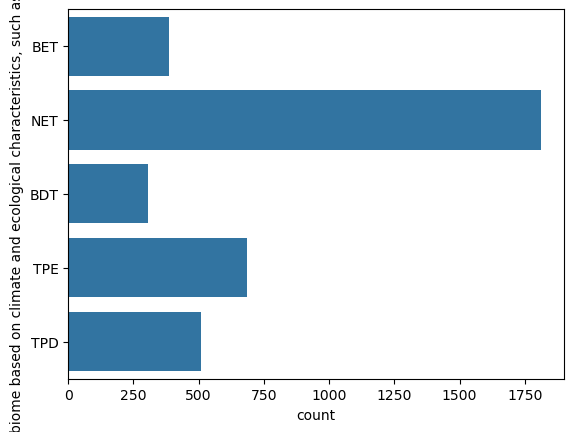

Visualizing ('CO2s', 'CO2 concentration in wet air inside chamber', 'ppm')


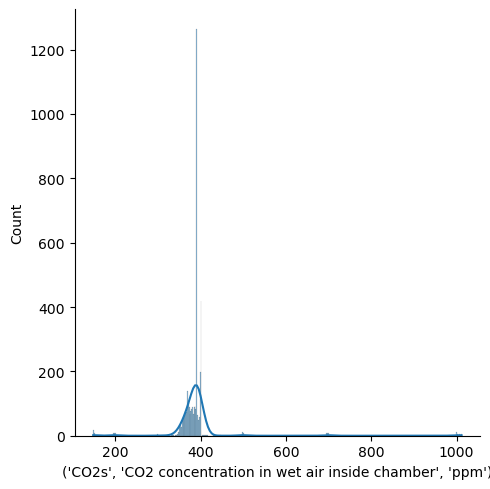

Visualizing ('Ci', 'Intercellular CO2 concentration in air', 'ppm')


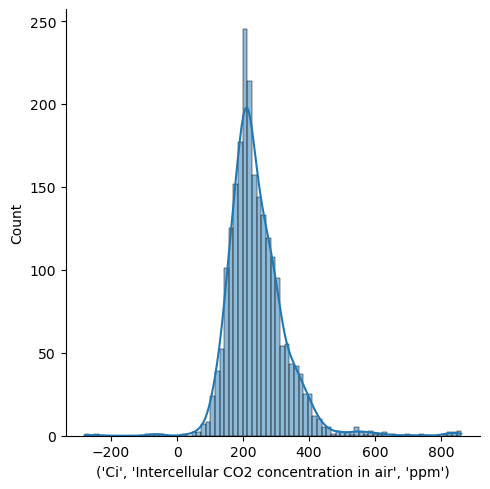

Visualizing ('gsw', 'Stomatal conductance to water vapor per leaf area', 'mol m-2 s-1')


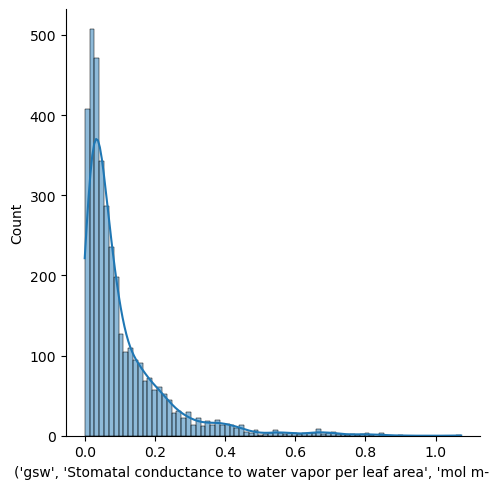

Visualizing ('dataContributor', 'Name of the individual or organization that contributed to the data', 1)


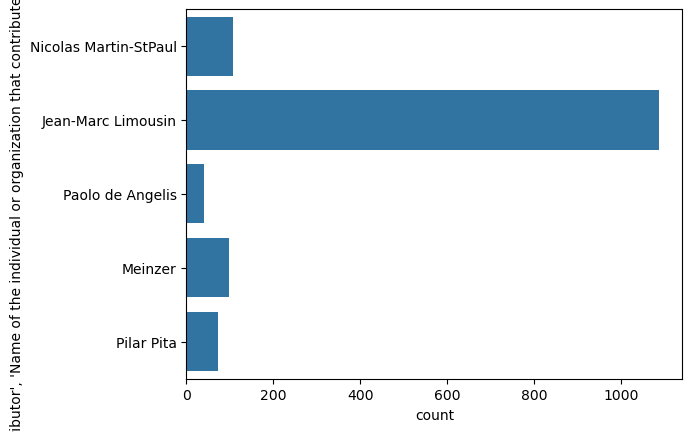

Visualizing ('date', 'Date of observation', 1)


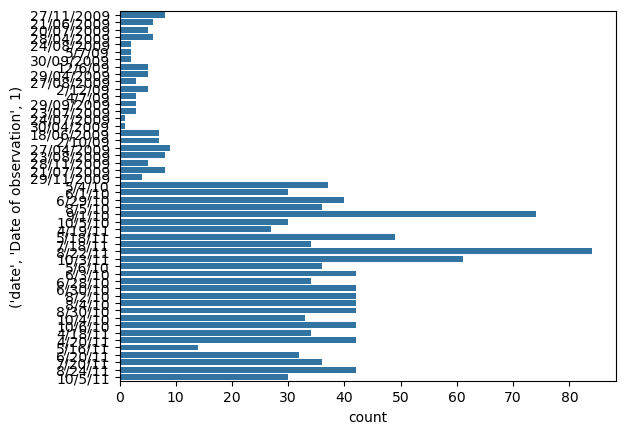

Visualizing ('experimentalManipulation', 'Experimental treatment(s) applied to the plant', 1)


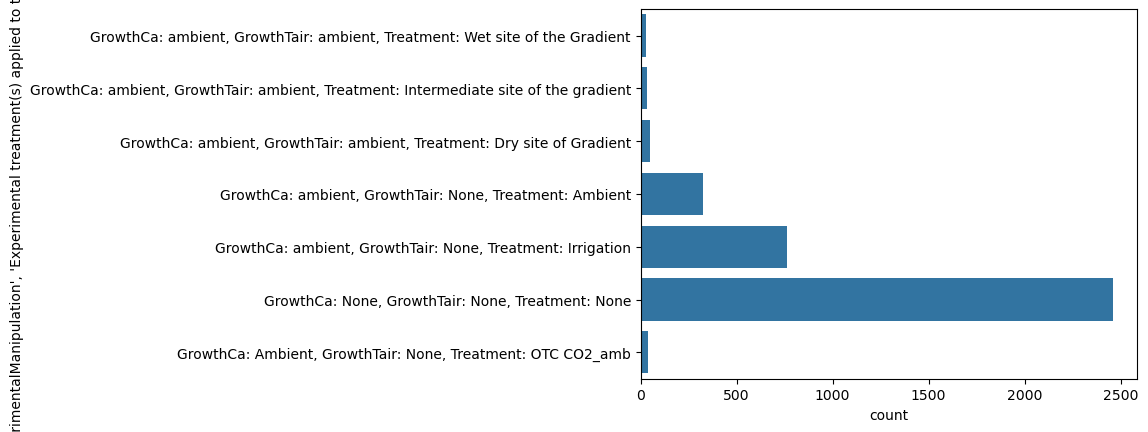

Visualizing ('growthEnvironment', 'Growth conditions of the plant, indicating whether it is growing under ambient (normal) or stressed conditions', 1)


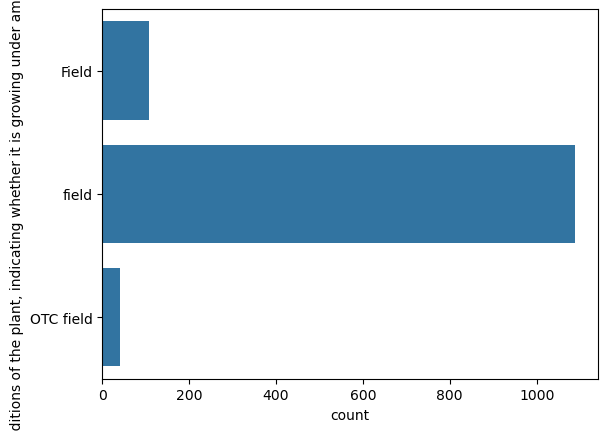

Visualizing ('measurementDevice', 'Name of the instrument that collected data', 1)


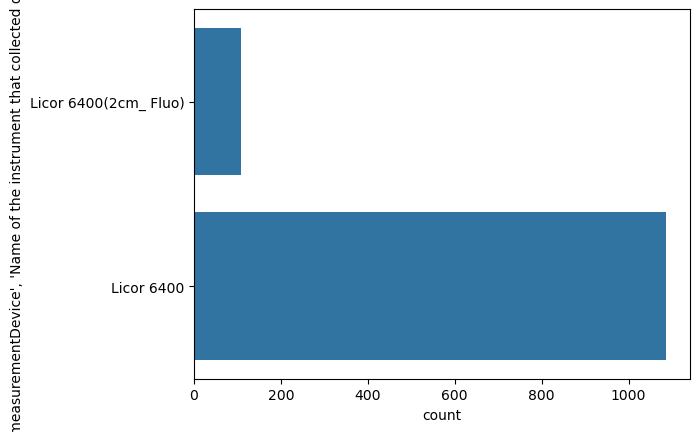

Visualizing ('LAI', 'The ratio of the leaf area to the ground area, which determines plant growth and development patterns', 'm-2 m-2')


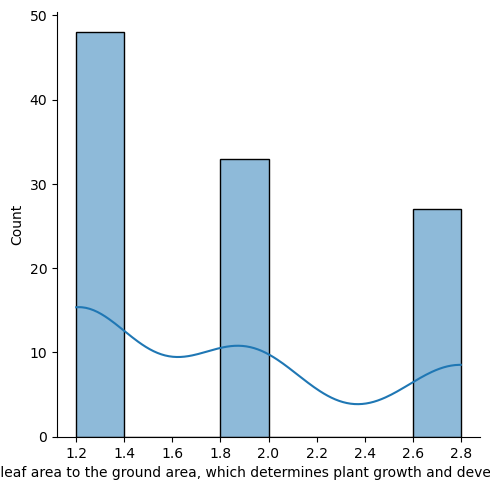

Visualizing ('plantLeaf', 'Leaf lifespan strategy of the plant, categorizing it as evergreen or deciduous based on leaf retention patterns', 1)


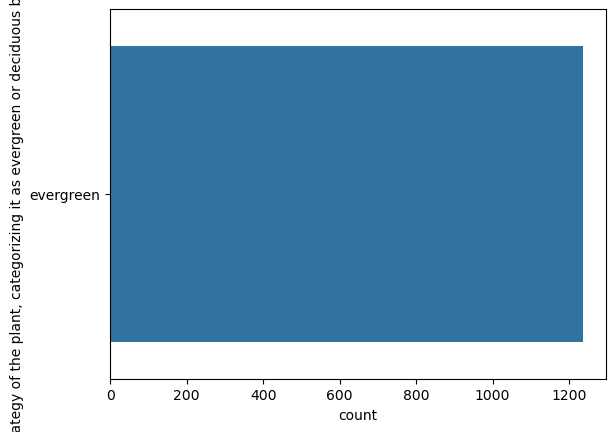

Visualizing ('siteIdentifier', 'Location descriptor of where data was collected', 1)


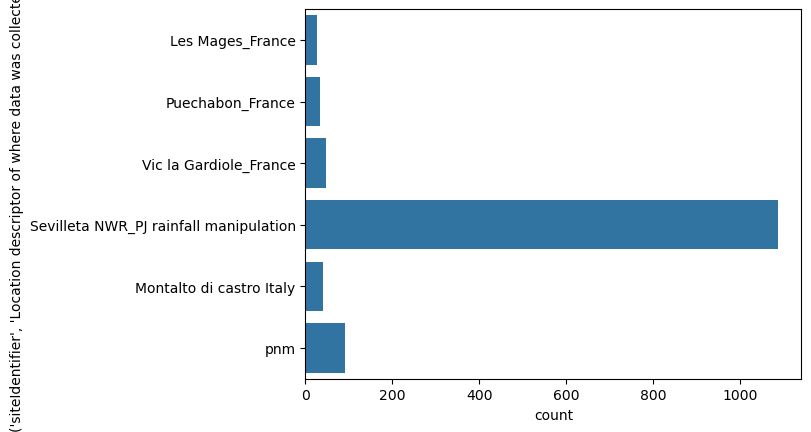

Visualizing ('Qin', 'In-chamber photosynthetic flux density (PPFD) incident on the leaf, quanta per area', 'μmol m-2 s-1')


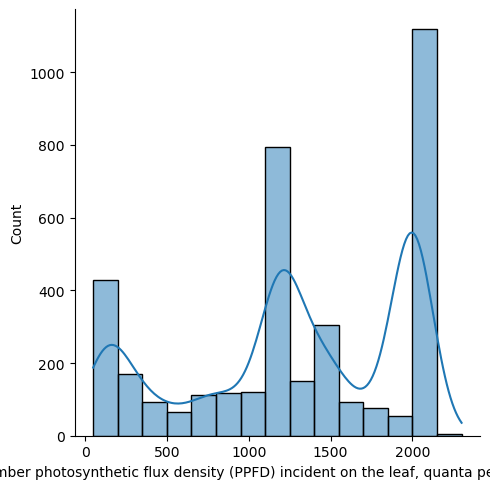

Visualizing ('Patm', 'Atmospheric pressure of the air', 'kPa')


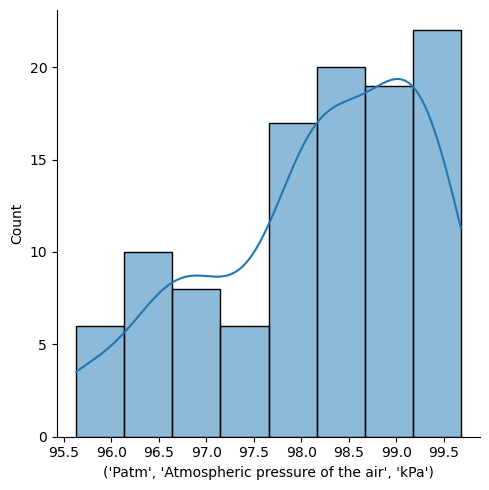

Visualizing ('A', 'Net CO2 exchange per leaf area', 'μmol m-2 s-1')


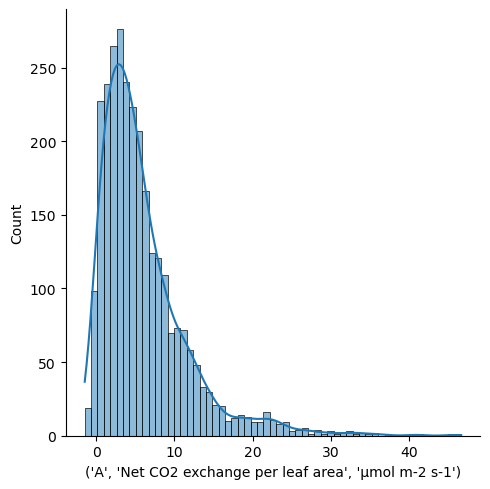

Visualizing ('plantForm', 'Life form of the plant, categorizing it as tree, shrub, grass, crop, savanna, etc., based on growth form and ecological function', 1)


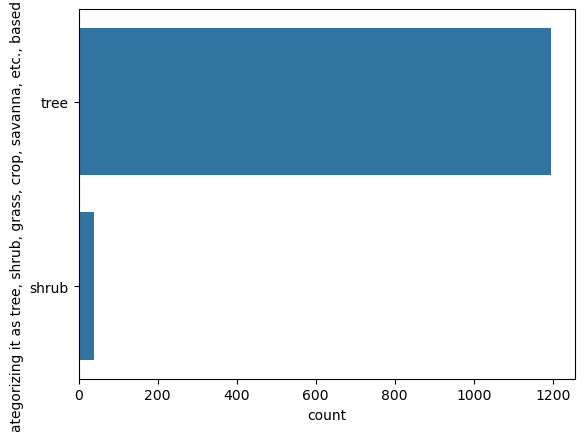

Visualizing ('RHr', 'Relative humidity of air entering the chamber', '%')


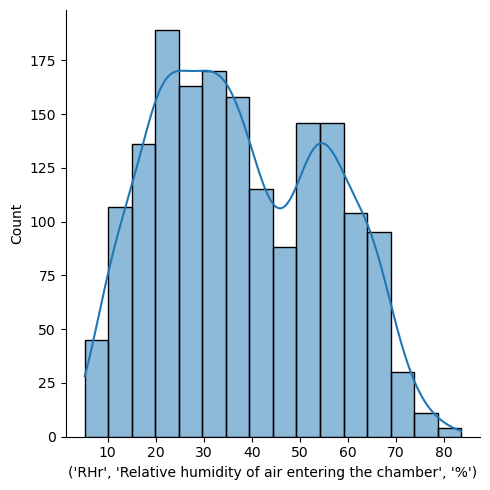

Visualizing ('season', 'Season when the measurement was collected', 1)
Column is empty, skipping visualization.
Visualizing ('species', 'Full species name and subspecies if applicable', 1)


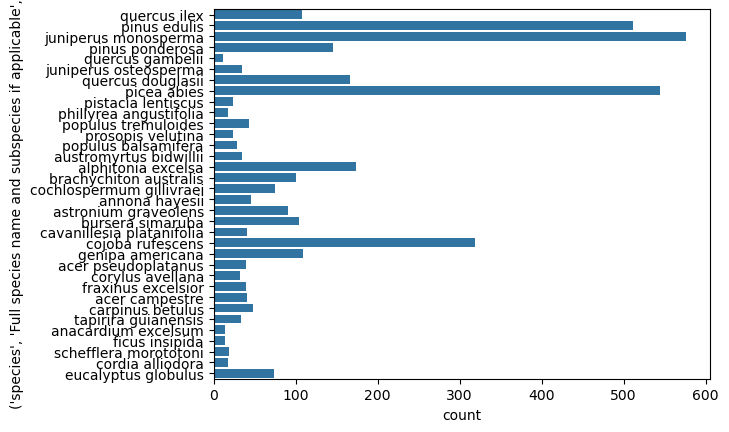

Visualizing ('Tair', 'Air temperature inside the chamber', 'degree_C')


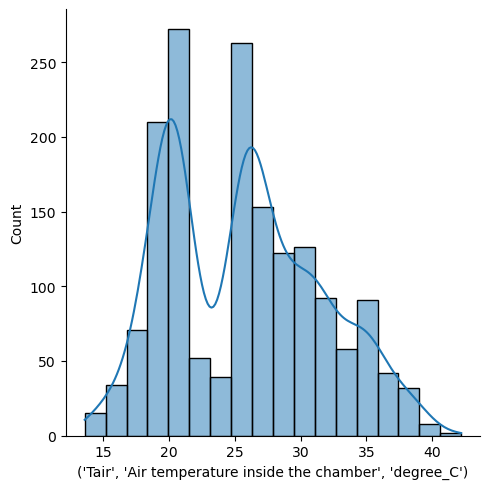

Visualizing ('time', 'Time of observation', 1)


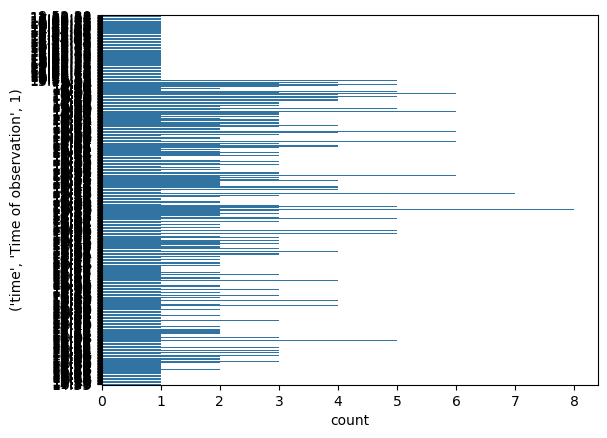

Visualizing ('Tleaf', 'Leaf surface temperature', 'degree_C')


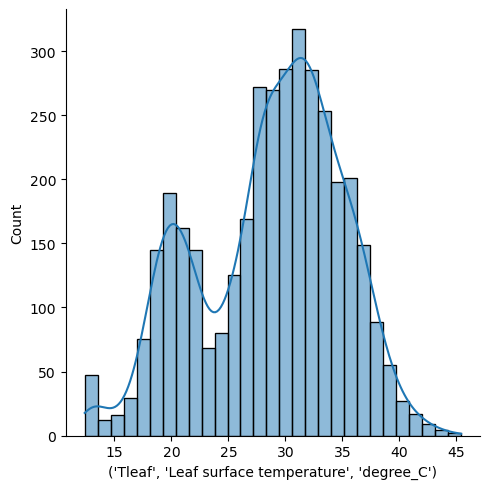

Visualizing ('plantHeight', 'The height of the plant measured', 'm')


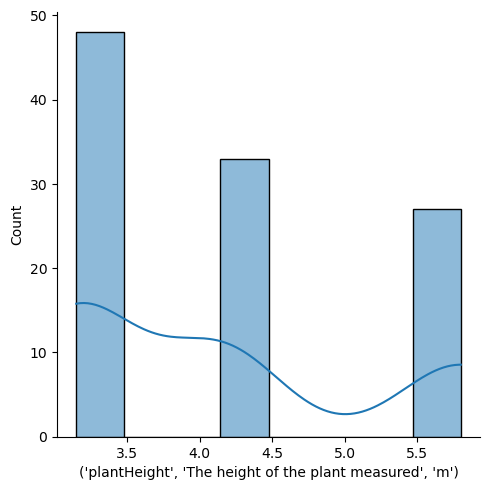

Visualizing ('E', 'Transpiration rate of H2O per leaf area', 'mmol m-2 s-1')


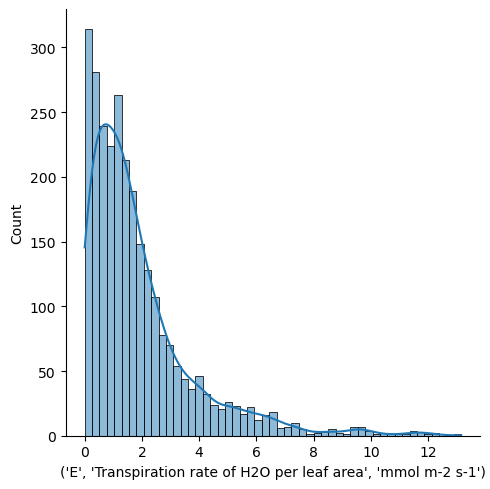

Visualizing ('plantType', 'Classification of plant as either gymnosperm or angiosperm, indicating differences in reproductive structures and evolutionary lineage', 1)


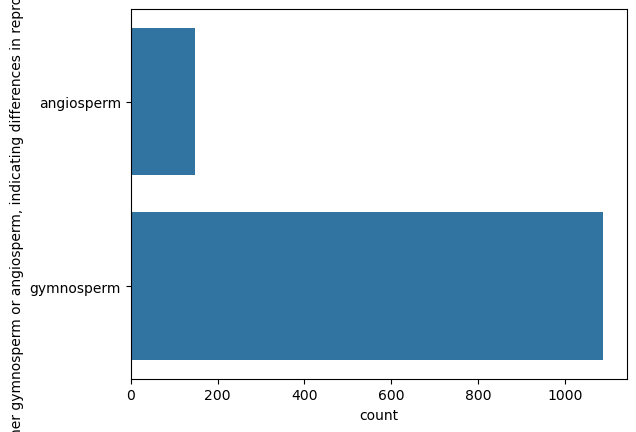

Visualizing ('latitudeY', 'Latitude coordinate of the site', 'degree')


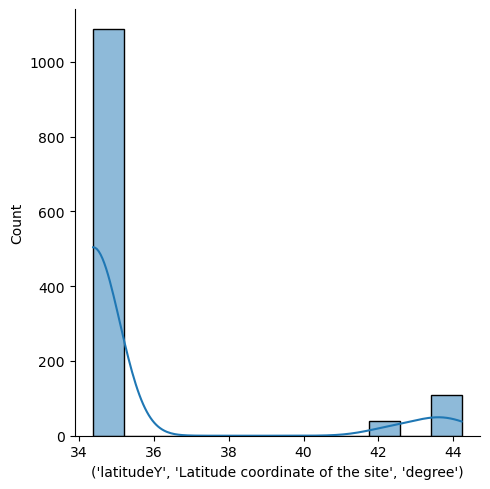

Visualizing ('longitudeX', 'Longitude coordinate of the site', 'degree')


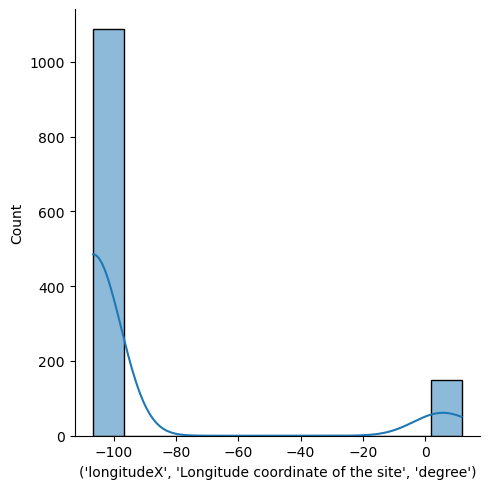

In [160]:
# Iterate over filtered_standard_data columns and visualize
for col in filtered_standard_data.columns:
    print(f"Visualizing {col}")
    funcs.visualize_all_columns(filtered_standard_data[col])

---
---
## 4. Quality Control

---
### 4.1. Strings

In [161]:
# general string cleaning
def clean_string_columns(df):
    # Select only object (string) dtype columns
    string_columns = df.select_dtypes(include=['object']).columns
    df.loc[:, string_columns] = df.loc[:, string_columns].apply(lambda col: col.str.strip().str.lower().str.replace('_', ' '))
    return df

# Apply the function to your DataFrame
filtered_standard_data = clean_string_columns(filtered_standard_data)

In [162]:
# Replace specific values with None
values_to_replace = [-999, -9999, 'none', 'None', np.nan]
filtered_standard_data = filtered_standard_data.replace(values_to_replace, None)

---
### 4.2. Measurement device
There is an extra string for licor 6400 in this data, so just set it to licor 6400

In [163]:
# add measurement device
device = 'licor 6400'
filtered_standard_data[('measurementDevice', 'Name of the instrument that collected data', 1)] = device

---
### 4.3. Season
This should be calculated where possible

---
### 4.4 Plant height

In [165]:
# plant height
filtered_standard_data[('plantHeight', 'The height of the plant measured', 'm')].unique()

array([5.8, 4.15, 3.15, None], dtype=object)

---
### 4.x. Plant form

In [166]:
filtered_standard_data[('plantForm', 
                        'Life form of the plant, categorizing it as tree, shrub, grass, crop, savanna, etc., based on growth form and ecological function', 
                        1)].unique()

array(['tree', None, 'shrub'], dtype=object)

---
### 4.x. Data contributor

In [168]:
# remove extra stuff from the contributor name
filtered_standard_data[('dataContributor',
                        'Name of the individual or organization that contributed to the data',
                        1)].unique()

array(['nicolas martin-stpaul', 'jean-marc limousin', None,
       'paolo de angelis', 'meinzer', 'pilar pita'], dtype=object)

---
### 4.x. Environmental manipulation

In [170]:
filtered_standard_data[('experimentalManipulation', 
                        'Experimental treatment(s) applied to the plant', 
                        1)].unique()

array(['growthca: ambient, growthtair: ambient, treatment: wet site of the gradient',
       'growthca: ambient, growthtair: ambient, treatment: intermediate site of the gradient',
       'growthca: ambient, growthtair: ambient, treatment: dry site of gradient',
       'growthca: ambient, growthtair: none, treatment: ambient',
       'growthca: ambient, growthtair: none, treatment: irrigation',
       'growthca: none, growthtair: none, treatment: none',
       'growthca: ambient, growthtair: none, treatment: otc co2 amb'],
      dtype=object)

In [171]:
replacements = {'growthca: ambient, growthtair: ambient, treatment: wet site of the gradient':'water',
                'growthca: ambient, growthtair: ambient, treatment: intermediate site of the gradient':'water',
                'growthca: ambient, growthtair: ambient, treatment: dry site of gradient':'water',
                'growthca: ambient, growthtair: none, treatment: ambient':'ambient',
                'growthca: ambient, growthtair: none, treatment: irrigation':'water',
                'growthca: none, growthtair: none, treatment: none':np.nan,
                'growthca: ambient, growthtair: none, treatment: otc co2 amb':'ambient'}
filtered_standard_data[('experimentalManipulation', 
                        'Experimental treatment(s) applied to the plant', 
                        1)] = filtered_standard_data[('experimentalManipulation', 
                                                      'Experimental treatment(s) applied to the plant', 
                                                      1)].replace(replacements)

In [172]:
filtered_standard_data[('experimentalManipulation', 
                        'Experimental treatment(s) applied to the plant', 
                        1)].unique()

array(['water', 'ambient', nan], dtype=object)

---
### 4.x. Growth environment

In [173]:
filtered_standard_data[('growthEnvironment', 
                        'Growth conditions of the plant, indicating whether it is growing under ambient (normal) or stressed conditions', 
                        1)].unique()

array(['field', None, 'otc field'], dtype=object)

In [174]:
replacements = {'field':'open',
                'otc field':'open top chamber'}
filtered_standard_data[('growthEnvironment', 
                        'Growth conditions of the plant, indicating whether it is growing under ambient (normal) or stressed conditions', 
                        1)] = filtered_standard_data[('growthEnvironment', 
                                                      'Growth conditions of the plant, indicating whether it is growing under ambient (normal) or stressed conditions', 
                                                      1)].replace(replacements)

In [175]:
filtered_standard_data[('growthEnvironment', 
                        'Growth conditions of the plant, indicating whether it is growing under ambient (normal) or stressed conditions', 
                        1)].unique()

array(['open', None, 'open top chamber'], dtype=object)

---
### 4.x. Plant Biome

In [177]:
filtered_standard_data[('plantBiome',
                        'Classification of the biome based on climate and ecological characteristics, such as arctic, boreal, temperate, or tropical',
                        1)].unique()

array(['bet', 'net', 'bdt', 'tpe', 'tpd'], dtype=object)

In [178]:
replacements = {'bet':'temperate',
                'net':'temperate',
                'bdt':'temperate',
                'tpe':'tropical',
                'tpd':'tropical'}
filtered_standard_data[('plantBiome',
                        'Classification of the biome based on climate and ecological characteristics, such as arctic, boreal, temperate, or tropical',
                        1)] = filtered_standard_data[('plantBiome',
                                                      'Classification of the biome based on climate and ecological characteristics, such as arctic, boreal, temperate, or tropical',
                                                      1)].replace(replacements)

In [179]:
filtered_standard_data[('plantBiome',
                        'Classification of the biome based on climate and ecological characteristics, such as arctic, boreal, temperate, or tropical',
                        1)].unique()

array(['temperate', 'tropical'], dtype=object)

In [180]:
filtered_standard_data

standard_variable,gbw,plantBiome,CO2s,Ci,gsw,dataContributor,date,experimentalManipulation,growthEnvironment,measurementDevice,...,season,species,Tair,time,Tleaf,plantHeight,E,plantType,latitudeY,longitudeX
standard_description,Boundary layer conductance to water vapor per leaf area,"Classification of the biome based on climate and ecological characteristics, such as arctic, boreal, temperate, or tropical",CO2 concentration in wet air inside chamber,Intercellular CO2 concentration in air,Stomatal conductance to water vapor per leaf area,Name of the individual or organization that contributed to the data,Date of observation,Experimental treatment(s) applied to the plant,"Growth conditions of the plant, indicating whether it is growing under ambient (normal) or stressed conditions",Name of the instrument that collected data,...,Season when the measurement was collected,Full species name and subspecies if applicable,Air temperature inside the chamber,Time of observation,Leaf surface temperature,The height of the plant measured,Transpiration rate of H2O per leaf area,"Classification of plant as either gymnosperm or angiosperm, indicating differences in reproductive structures and evolutionary lineage",Latitude coordinate of the site,Longitude coordinate of the site
unit,mol m-2 s-1,1,ppm,ppm,mol m-2 s-1,1,1,1,1,1,...,1,1,degree_C,1,degree_C,m,mmol m-2 s-1,1,degree,degree
4,None,temperate,391.47,251.358395,0.175809,nicolas martin-stpaul,27/11/2009,water,open,licor 6400,...,None,quercus ilex,19.93,8:52:30,18.36,5.8,0.002325,angiosperm,44.216667,4.133333
5,None,temperate,392.34,215.880258,0.065359,nicolas martin-stpaul,21/06/2009,water,open,licor 6400,...,None,quercus ilex,20.44,11:12:15,24.85,5.8,0.001296,angiosperm,44.216667,4.133333
6,None,temperate,396.99,236.524749,0.041581,nicolas martin-stpaul,20/07/2009,water,open,licor 6400,...,None,quercus ilex,28.42,11:30:24,35.37,5.8,0.001923,angiosperm,44.216667,4.133333
7,None,temperate,391.36,189.810753,0.107842,nicolas martin-stpaul,28/04/2009,water,open,licor 6400,...,None,quercus ilex,25.69,12:03:04,24.87,5.8,0.002535,angiosperm,44.216667,4.133333
8,None,temperate,396.34,245.146039,0.066538,nicolas martin-stpaul,27/11/2009,water,open,licor 6400,...,None,quercus ilex,21.66,13:50:53,20.53,5.8,0.000998,angiosperm,44.216667,4.133333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3695,None,temperate,354.180542,227.486152,0.412063,pilar pita,None,NaN,None,licor 6400,...,None,eucalyptus globulus,None,None,30.412889,None,8.475581,None,None,None
3696,None,temperate,353.518402,191.230231,0.266069,pilar pita,None,NaN,None,licor 6400,...,None,eucalyptus globulus,None,None,31.022032,None,6.654033,None,None,None


---
### 4.5. Dates/Times

#### A. If you have a ton of different datetime formats to contend with:
* Create a .csv `../data/temp/datetmes/{filename}_datetime_formatting.csv` with headers `source`, `datetime_formats`, `time_formats`, and `dayfirst`
* Assign a list of datetime formats, time formats, and dayfirst info (whether or not the date starts with a day) in `{filename}_datetime_formatting.csv`
    * Assign these special cases where necessary:
        * decimal_hours (time is in decimal hours), total_minutes (time is in total minutes), date_with_time (date contains time information), range_of_days (date is a range of days, e.g., 1-2 September 2024)
        * add more special case handling in the `funcs.process_datetime()` as needed
* Export filled in `../data/temp/datetmes/{filename}_datetime_formatting.csv` as `../data/temp/datetmes/{filename}_datetime_formatting_01.csv`
<\b>

In [186]:
# As you can see below, there is a mix of date formats. Annoying.
filtered_standard_data[('date', 'Date of observation', 1)].unique()

array(['27/11/2009', '21/06/2009', '20/07/2009', '28/04/2009',
       '24/08/2009', '5/7/09', '30/09/2009', '12/6/09', '29/04/2009',
       '27/08/2009', '2/12/09', '4/7/09', '29/09/2009', '23/07/2009',
       '24/07/2009', '30/04/2009', '18/06/2009', '2/10/09', '27/04/2009',
       '23/08/2009', '28/11/2009', '21/07/2009', '29/11/2009', '5/4/10',
       '6/1/10', '6/29/10', '8/5/10', '9/1/10', '10/5/10', '4/19/11',
       '5/18/11', '7/18/11', '8/22/11', '10/3/11', '5/6/10', '6/3/10',
       '6/28/10', '6/30/10', '8/2/10', '8/4/10', '8/30/10', '10/4/10',
       '10/6/10', '4/18/11', '4/20/11', '5/16/11', '6/20/11', '7/20/11',
       '8/24/11', '10/5/11', None], dtype=object)

In [192]:
date_grouped = filtered_standard_data.groupby([('dataContributor', 
                                           'Name of the individual or organization that contributed to the data', 
                                           1),
                                          ('siteIdentifier', 'Location descriptor of where data was collected', 1)])[[('date', 'Date of observation', 1)]].agg(lambda x: x.unique())
date_grouped.columns = date_grouped.columns.get_level_values(0)
date_grouped = date_grouped.reset_index()
date_grouped['source'] = date_grouped[('dataContributor', 'Name of the individual or organization that contributed to the data', 1)] +  ' ' + date_grouped[('siteIdentifier', 'Location descriptor of where data was collected', 1)]
date_grouped = date_grouped.drop(columns=[('dataContributor', 'Name of the individual or organization that contributed to the data', 1),
                                ('siteIdentifier', 'Location descriptor of where data was collected', 1)])
date_grouped = date_grouped[['source', 'date']]

In [194]:
time_grouped = filtered_standard_data.groupby([('dataContributor', 
                                           'Name of the individual or organization that contributed to the data', 
                                           1),
                                          ('siteIdentifier', 'Location descriptor of where data was collected', 1)])[[('time', 'Time of observation', 1)]].agg(lambda x: x.unique())
time_grouped.columns = time_grouped.columns.get_level_values(0)
time_grouped = time_grouped.reset_index()
time_grouped['source'] = time_grouped[('dataContributor', 'Name of the individual or organization that contributed to the data', 1)] +  ' ' + time_grouped[('siteIdentifier', 'Location descriptor of where data was collected', 1)]
time_grouped = time_grouped.drop(columns=[('dataContributor', 'Name of the individual or organization that contributed to the data', 1),
                                ('siteIdentifier', 'Location descriptor of where data was collected', 1)])
time_grouped = time_grouped[['source', 'time']]

In [201]:
grouped = date_grouped.merge(time_grouped, how='left', left_on='source', right_on='source')
grouped

standard_variable,source,date,time
0,jean-marc limousin sevilleta nwr pj rainfall m...,"[5/4/10, 6/1/10, 6/29/10, 8/5/10, 9/1/10, 10/5...","[7:52, 8:03, 8:23, 9:25, 9:34, 9:58, 11:23, 11..."
1,nicolas martin-stpaul les mages france,"[27/11/2009, 21/06/2009, 20/07/2009, 28/04/200...","[8:52:30, 11:12:15, 11:30:24, 12:03:04, 13:50:..."
2,nicolas martin-stpaul puechabon france,"[5/7/09, 30/09/2009, 12/6/09, 29/04/2009, 27/0...","[5:24:08, 7:07:07, 8:04:01, 8:56:01, 13:43:20,..."
3,nicolas martin-stpaul vic la gardiole france,"[18/06/2009, 2/10/09, 27/04/2009, 23/08/2009, ...","[7:25:35, 8:13:48, 8:20:49, 8:21:44, 8:23:51, ..."
4,paolo de angelis montalto di castro italy,[None],"[17:15, 7:58, 7:04, 17:02, 16:16, 14:14, 6:54,..."


In [202]:
grouped['datetime_formats'], grouped['time_formats'], grouped['dayfirst'] = None, None, None
grouped.index.name = ''
grouped.to_csv(f'../data/temp/datetimes/{filename}_datetime_formatting_temp.csv')

In [203]:
df = pd.read_csv(f'../data/temp/datetimes/{filename}_datetime_formatting.csv', index_col=0, encoding='utf-8')
df.head(3)

,source,date,time,datetime_formats,time_formats,dayfirst
0,jean-marc limousin sevilleta nwr pj rainfall m...,['5/4/10' '6/1/10' '6/29/10' '8/5/10' '9/1/10'...,['7:52' '8:03' '8:23' '9:25' '9:34' '9:58' '11...,[‘%m/%d/%y’],[‘%H:%M’],[False]
1,nicolas martin-stpaul les mages france,['27/11/2009' '21/06/2009' '20/07/2009' '28/04...,['8:52:30' '11:12:15' '11:30:24' '12:03:04' '1...,[‘%d/%m/%Y’],[‘%H:%M:%S’],[True]
2,nicolas martin-stpaul puechabon france,['5/7/09' '30/09/2009' '12/6/09' '29/04/2009' ...,['5:24:08' '7:07:07' '8:04:01' '8:56:01' '13:4...,"[‘%d/%m/%Y’, ‘%d/%m/%y’]",[‘%H:%M:%S’],"[True, True]"


In [206]:
# convert the df into a dictionary format
source_formats = {
    row["source"]: {
        "datetime_formats": eval(row["datetime_formats"].replace("‘", "'").replace("’", "'")),
        "time_formats": eval(row["time_formats"].replace("‘", "'").replace("’", "'")),
        "dayfirst": eval(row["dayfirst"])
    }
    for _, row in df.iterrows()
}

# add source to filtered_standard_data
filtered_standard_data[("source", "dummy description", 1)] = (
    filtered_standard_data[("dataContributor", "Name of the individual or organization that contributed to the data", 1)]
    + " " +
    filtered_standard_data[("siteIdentifier", "Location descriptor of where data was collected", 1)]
)

# add missing time column
filtered_standard_data[('time', 'Time of observation', 1)] = None

In [207]:
# apply processing by group
results = []
for source, group in filtered_standard_data.groupby(("source", "dummy description", 1)):
    formats = source_formats.get(source, {})
    group[[('original_date', 'Original date', 1), ('original_time', 'Original time', 1), ('year', 'Year of observation', 1), ('month', 'Month of observation', 1), ('day', 'Day of observation', 1), ('time', 'Time of observation', 1)]] = group.apply(
        lambda x: pd.Series(funcs.process_datetime(x, formats)), axis=1
    )
    results.append(group)

# Concatenate the processed groups
filtered_standard_data2 = pd.concat(results)
filtered_standard_data2.head(3)

standard_variable,gbw,plantBiome,CO2s,Ci,gsw,dataContributor,date,experimentalManipulation,growthEnvironment,measurementDevice,...,E,plantType,latitudeY,longitudeX,source,original_date,original_time,year,month,day
standard_description,Boundary layer conductance to water vapor per leaf area,"Classification of the biome based on climate and ecological characteristics, such as arctic, boreal, temperate, or tropical",CO2 concentration in wet air inside chamber,Intercellular CO2 concentration in air,Stomatal conductance to water vapor per leaf area,Name of the individual or organization that contributed to the data,Date of observation,Experimental treatment(s) applied to the plant,"Growth conditions of the plant, indicating whether it is growing under ambient (normal) or stressed conditions",Name of the instrument that collected data,...,Transpiration rate of H2O per leaf area,"Classification of plant as either gymnosperm or angiosperm, indicating differences in reproductive structures and evolutionary lineage",Latitude coordinate of the site,Longitude coordinate of the site,dummy description,Original date,Original time,Year of observation,Month of observation,Day of observation
unit,mol m-2 s-1,1,ppm,ppm,mol m-2 s-1,1,1,1,1,1,...,mmol m-2 s-1,1,degree,degree,1,1,1,1,1,1
112,None,temperate,382.0,344.0,0.01,jean-marc limousin,5/4/10,ambient,open,licor 6400,...,0.18,gymnosperm,34.39,-106.53,jean-marc limousin sevilleta nwr pj rainfall m...,5/4/10,None,2010,5,4
113,None,temperate,360.0,176.0,0.025,jean-marc limousin,5/4/10,ambient,open,licor 6400,...,0.41,gymnosperm,34.39,-106.53,jean-marc limousin sevilleta nwr pj rainfall m...,5/4/10,None,2010,5,4
114,None,temperate,362.0,155.0,0.034,jean-marc limousin,5/4/10,ambient,open,licor 6400,...,0.51,gymnosperm,34.39,-106.53,jean-marc limousin sevilleta nwr pj rainfall m...,5/4/10,None,2010,5,4


---
### 4.10. Species names
For this Lin 2015 data, I wanted a visual aid to make sure I was adjusting species names correctly, so I generated a unique ID for each data source and species. That way, I can capture when a data source recorded information for multiple species

In [208]:
filtered_standard_data2[('species', 'Full species name and subspecies if applicable', 1)].unique()

array(['pinus edulis', 'juniperus monosperma', 'quercus ilex',
       'pistacia lentiscus', 'phillyrea angustifolia'], dtype=object)

In [209]:
# instantiate species checklist
u_species = filtered_standard_data2[[('species', 'Full species name and subspecies if applicable', 1),
                       ('plantType', 'Classification of plant as either gymnosperm or angiosperm, indicating differences in reproductive structures and evolutionary lineage', 1),
                       ('plantLeaf', 'Leaf lifespan strategy of the plant, categorizing it as evergreen or deciduous based on leaf retention patterns', 1),
                       ('plantForm', 'Life form of the plant, categorizing it as tree, shrub, grass, crop, savanna, etc., based on growth form and ecological function', 1)]].drop_duplicates()
u_species.columns = u_species.columns.get_level_values(0)
u_species = u_species.rename(columns={'species':'unadjudicatedName'})
u_species = u_species.sort_values(by='unadjudicatedName')
u_species

standard_variable,unadjudicatedName,plantType,plantLeaf,plantForm
623,juniperus monosperma,gymnosperm,evergreen,tree
2124,phillyrea angustifolia,angiosperm,evergreen,shrub
112,pinus edulis,gymnosperm,evergreen,tree
2101,pistacia lentiscus,angiosperm,evergreen,shrub
4,quercus ilex,angiosperm,evergreen,tree


---
#### 4.10.1 Instantiate the species lookup table as `filename_species_lookup.csv`

In [210]:
# add missing columns
u_species['acceptedName'] = None
u_species['nameAuthor'] = None
u_species['nameAuthority'] = None
u_species['nameCategory'] = None
u_species['nameAdjudicator'] = None

# export checklist
u_species.to_csv(f'../data/temp/species/{filename}_species_lookup.csv')

---
### 4.10.2 Fill in the lookup table information save as `filename_species_lookup_01.csv`
We recommend passing this task on to an expert who can parse through synonymous, mispelled, and misapplied names

In [225]:
# load edited species checklist (species_checklist_01)
species_checklist = pd.read_csv(f'../data/temp/species/{filename}_species_lookup_01.csv', index_col=0)
species_checklist = species_checklist.replace({np.nan: None})
species_checklist

,unadjudicatedName,plantType,plantLeaf,plantForm,acceptedName,nameAuthor,nameAuthority,nameCategory,nameAdjudicator
623,juniperus monosperma,gymnosperm,evergreen,tree,juniperus monosperma,None,None,species,None
2124,phillyrea angustifolia,angiosperm,evergreen,shrub,phillyrea angustifolia,None,None,species,None
112,pinus edulis,gymnosperm,evergreen,tree,pinus edulis,None,None,species,None
2101,pistacia lentiscus,angiosperm,evergreen,shrub,pistacia lentiscus,None,None,species,None
4,quercus ilex,angiosperm,evergreen,tree,quercus ilex,None,None,species,None


#### 4.10.3. Format the lookup table headers for merging new columns to the data

In [226]:
# make single headers into multi-headers
new_columns = pd.MultiIndex.from_tuples([
    ('unadjudicatedName', 'Full species name and subspecies if applicable', 1),  # Matching the multi-header in filtered_standard_data2
    ('plantType', 'Classification of plant as either gymnosperm or angiosperm, indicating differences in reproductive structures and evolutionary lineage', 1),
    ('plantLeaf', 'Leaf lifespan strategy of the plant, categorizing it as evergreen or deciduous based on leaf retention patterns', 1),
    ('plantForm', 'Life form of the plant, categorizing it as tree, shrub, grass, crop, savanna, etc., based on growth form and ecological function', 1),
    ('acceptedName', 'The accepted species name assigned by the adjudicator', 1),
    ('nameAuthor', 'The author of the accepted species name', 1),
    ('nameAuthority', 'The authority that was referenced to assign the accepted species name', 1),
    ('nameCategory', 'The taxonomic heirarchy level at which the plant was named (family, genus, species, subspecies, variety, type)', 1),
    ('nameAdjudicator', 'The expert that assigned an unadjudicated species name to an accepted species name', 1)
])
species_checklist.columns = new_columns

#### 4.10.4. Merge the species data to filtered_standard_data

In [227]:
# merge checklist to filtered_standard_data
merged_df = pd.merge(
    filtered_standard_data2,
    species_checklist,
    left_on=[('species', 'Full species name and subspecies if applicable', 1)],
    right_on=[('unadjudicatedName', 'Full species name and subspecies if applicable', 1)],
    how='left'
)
merged_df.head(3)

,gbw,plantBiome,CO2s,Ci,gsw,dataContributor,date,experimentalManipulation,growthEnvironment,measurementDevice,...,day,unadjudicatedName,plantType_y,plantLeaf_y,plantForm_y,acceptedName,nameAuthor,nameAuthority,nameCategory,nameAdjudicator
,Boundary layer conductance to water vapor per leaf area,"Classification of the biome based on climate and ecological characteristics, such as arctic, boreal, temperate, or tropical",CO2 concentration in wet air inside chamber,Intercellular CO2 concentration in air,Stomatal conductance to water vapor per leaf area,Name of the individual or organization that contributed to the data,Date of observation,Experimental treatment(s) applied to the plant,"Growth conditions of the plant, indicating whether it is growing under ambient (normal) or stressed conditions",Name of the instrument that collected data,...,Day of observation,Full species name and subspecies if applicable,"Classification of plant as either gymnosperm or angiosperm, indicating differences in reproductive structures and evolutionary lineage","Leaf lifespan strategy of the plant, categorizing it as evergreen or deciduous based on leaf retention patterns","Life form of the plant, categorizing it as tree, shrub, grass, crop, savanna, etc., based on growth form and ecological function",The accepted species name assigned by the adjudicator,The author of the accepted species name,The authority that was referenced to assign the accepted species name,"The taxonomic heirarchy level at which the plant was named (family, genus, species, subspecies, variety, type)",The expert that assigned an unadjudicated species name to an accepted species name
,mol m-2 s-1,1,ppm,ppm,mol m-2 s-1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
0,None,temperate,382.0,344.0,0.01,jean-marc limousin,5/4/10,ambient,open,licor 6400,...,4,pinus edulis,gymnosperm,evergreen,tree,pinus edulis,None,None,species,None
1,None,temperate,360.0,176.0,0.025,jean-marc limousin,5/4/10,ambient,open,licor 6400,...,4,pinus edulis,gymnosperm,evergreen,tree,pinus edulis,None,None,species,None
2,None,temperate,362.0,155.0,0.034,jean-marc limousin,5/4/10,ambient,open,licor 6400,...,4,pinus edulis,gymnosperm,evergreen,tree,pinus edulis,None,None,species,None


#### 4.10.5. Drop some overlapped columns from the merged dataframe

In [228]:
# rename columns
columns_to_drop = [('plantType_x',
                    'Classification of plant as either gymnosperm or angiosperm, indicating differences in reproductive structures and evolutionary lineage',
                    1),
                   ('plantLeaf_x',
                    'Leaf lifespan strategy of the plant, categorizing it as evergreen or deciduous based on leaf retention patterns',
                    1),
                   ('plantForm_x',
                    'Life form of the plant, categorizing it as tree, shrub, grass, crop, savanna, etc., based on growth form and ecological function',
                    1),
                   ('date', 'Date of observation', 1),
                   ('original_date', 'Original date', 1),
                   ('original_time', 'Original time', 1),
                   ('species', 'Full species name and subspecies if applicable', 1),
                   ('source', 'dummy description', 1)]

# Drop the specified columns
merged_df = merged_df.drop(columns=columns_to_drop, axis=1)
merged_df.columns = pd.MultiIndex.from_tuples([
    (col[0].replace('_y', ''), *col[1:]) for col in merged_df.columns
])
merged_df.head(3)

,gbw,plantBiome,CO2s,Ci,gsw,dataContributor,experimentalManipulation,growthEnvironment,measurementDevice,LAI,...,day,unadjudicatedName,plantType,plantLeaf,plantForm,acceptedName,nameAuthor,nameAuthority,nameCategory,nameAdjudicator
,Boundary layer conductance to water vapor per leaf area,"Classification of the biome based on climate and ecological characteristics, such as arctic, boreal, temperate, or tropical",CO2 concentration in wet air inside chamber,Intercellular CO2 concentration in air,Stomatal conductance to water vapor per leaf area,Name of the individual or organization that contributed to the data,Experimental treatment(s) applied to the plant,"Growth conditions of the plant, indicating whether it is growing under ambient (normal) or stressed conditions",Name of the instrument that collected data,"The ratio of the leaf area to the ground area, which determines plant growth and development patterns",...,Day of observation,Full species name and subspecies if applicable,"Classification of plant as either gymnosperm or angiosperm, indicating differences in reproductive structures and evolutionary lineage","Leaf lifespan strategy of the plant, categorizing it as evergreen or deciduous based on leaf retention patterns","Life form of the plant, categorizing it as tree, shrub, grass, crop, savanna, etc., based on growth form and ecological function",The accepted species name assigned by the adjudicator,The author of the accepted species name,The authority that was referenced to assign the accepted species name,"The taxonomic heirarchy level at which the plant was named (family, genus, species, subspecies, variety, type)",The expert that assigned an unadjudicated species name to an accepted species name
,mol m-2 s-1,1,ppm,ppm,mol m-2 s-1,1,1,1,1,m-2 m-2,...,1,1,1,1,1,1,1,1,1,1
0,None,temperate,382.0,344.0,0.01,jean-marc limousin,ambient,open,licor 6400,None,...,4,pinus edulis,gymnosperm,evergreen,tree,pinus edulis,None,None,species,None
1,None,temperate,360.0,176.0,0.025,jean-marc limousin,ambient,open,licor 6400,None,...,4,pinus edulis,gymnosperm,evergreen,tree,pinus edulis,None,None,species,None
2,None,temperate,362.0,155.0,0.034,jean-marc limousin,ambient,open,licor 6400,None,...,4,pinus edulis,gymnosperm,evergreen,tree,pinus edulis,None,None,species,None


---
---
## 5. Unit conversion

In [230]:
# ensure numeric columns are float instead of object dtypes
numeric_cols = []
for col in merged_df.columns:
    try:
        pd.to_numeric(merged_df[col], errors='raise')
        numeric_cols.append(col)
    except ValueError:
        pass  # Skip non-numeric columns

# convert
for col in numeric_cols:
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce').astype('float32')

# replace NaN with None in numeric columns
merged_df[numeric_cols] = merged_df[numeric_cols].map(lambda x: None if pd.isna(x) else x)

In [231]:
# Create a deep copy of merged_df
merged_df_2 = merged_df.copy(deep=True)
merged_df_2, preconverted_cols, converted_cols = funcs.check_and_convert_units(column_standards, merged_df_2)

Mismatch found: gbw (Boundary layer conductance to water vapor per leaf area) - mol m-2 s-1 to mmol m-2 s-1
Error converting from mol m-2 s-1 to mmol m-2 s-1: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
Converted units and updated header.
Mismatch found: CO2s (CO2 concentration in wet air inside chamber) - ppm to μmol mol-1
Converted data from ppm to μmol mol-1: min=300.1000061035156, max=447.0
Converted units and updated header.
Mismatch found: Ci (Intercellular CO2 concentration in air) - ppm to μmol mol-1
Converted data from ppm to μmol mol-1: min=45.400001525878906, max=374.3025207519531
Converted units and updated header.
Mismatch found: gsw (Stomatal conductance to water vapor per leaf area) - mol m-2 s-1 to mmol m-2 s-1
Converted data from mol m-2 s-1 to mmol m-2 s-1: min=1.7999999690800905, max=259.99999046325684
Converted units and updated header.


---
### 5.1. Visualize and confirm unit conversions

Visualizing ('gbw', 'Boundary layer conductance to water vapor per leaf area', 'mol m-2 s-1') and ('gbw', 'Boundary layer conductance to water vapor per leaf area', 'mmol m-2 s-1')


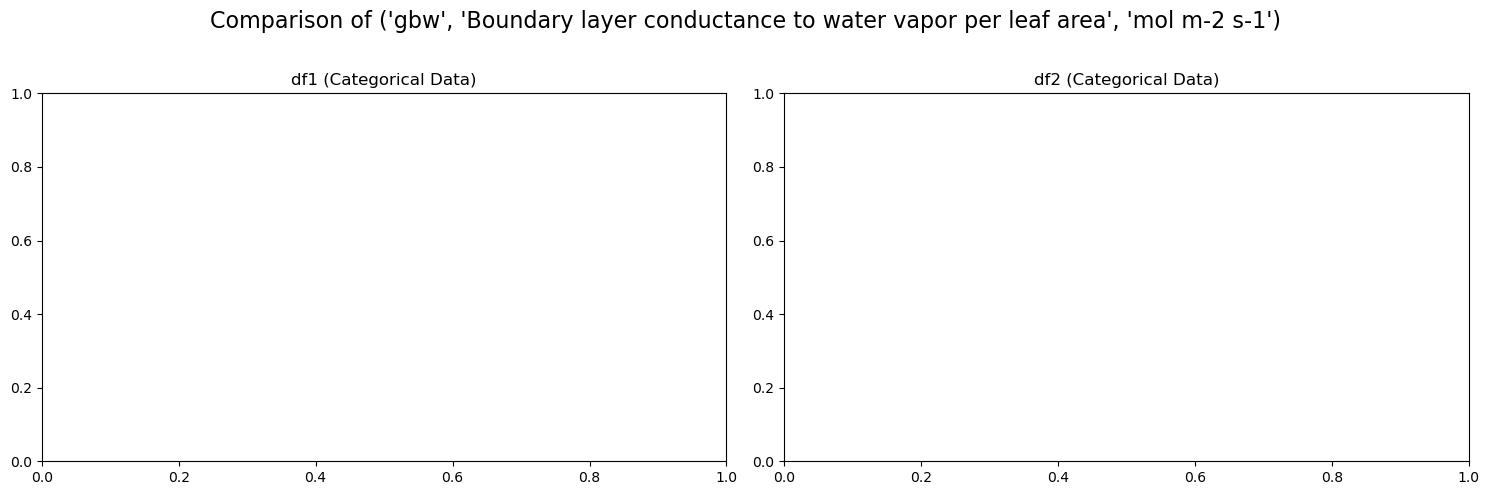

Visualizing ('CO2s', 'CO2 concentration in wet air inside chamber', 'ppm') and ('CO2s', 'CO2 concentration in wet air inside chamber', 'μmol mol-1')


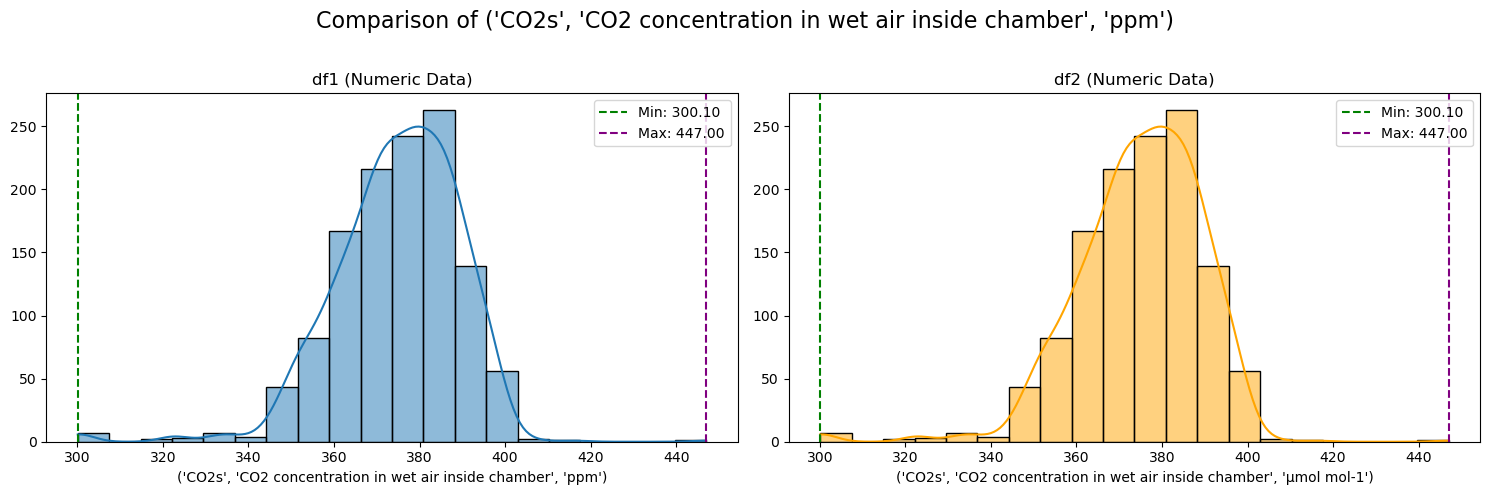

Visualizing ('Ci', 'Intercellular CO2 concentration in air', 'ppm') and ('Ci', 'Intercellular CO2 concentration in air', 'μmol mol-1')


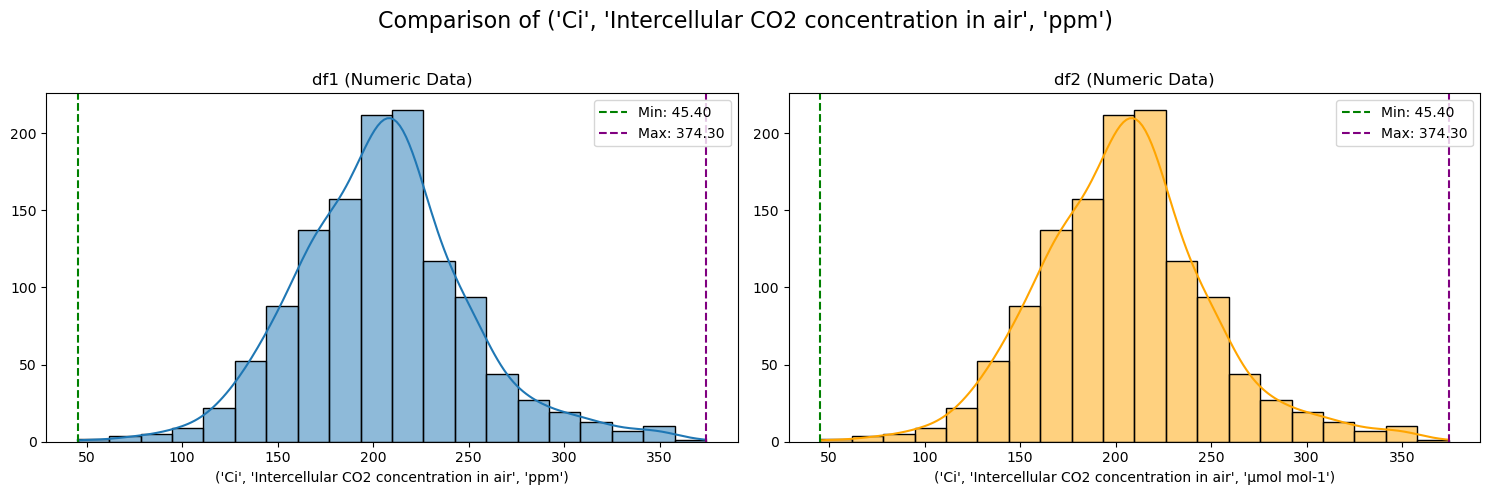

Visualizing ('gsw', 'Stomatal conductance to water vapor per leaf area', 'mol m-2 s-1') and ('gsw', 'Stomatal conductance to water vapor per leaf area', 'mmol m-2 s-1')


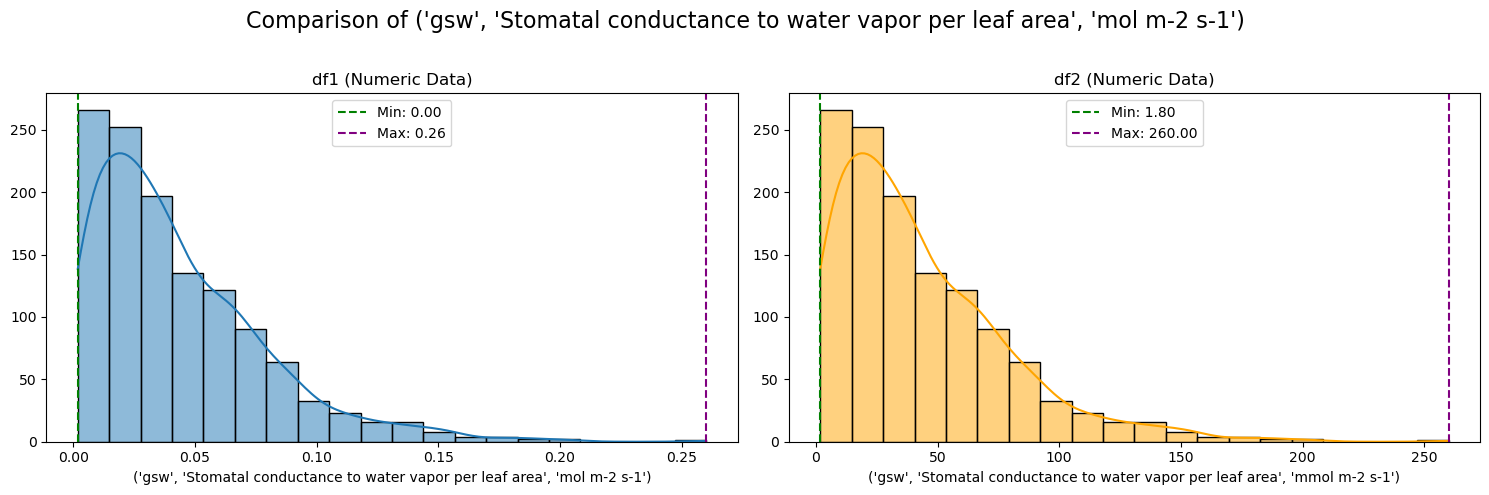

In [232]:
funcs.compare_col_hists(merged_df, preconverted_cols, merged_df_2, converted_cols)

---
### 5.2. Drop out-of-range values per ESS-Dive leaf-gas-exchange info

In [233]:
oor = pd.read_csv('../data/supp/info_measured_variables.csv')
oor

,variableName,variableUnit,variableDescription,expectedValueRangeMin,expectedValueRangeMax
0,date,YYYY-MM-DD,Date of observation,NaN,NaN
1,time,HH:MM:SS,Time of observation,NaN,NaN
2,record,1,Observation record number,NaN,NaN
3,area,cm-2,Leaf area,NaN,NaN
4,A,µmol m-2 s-1,Net CO₂ exchange per leaf area,-20.0,120.0
5,Amax,µmol m-2 s-1,Highest rate of light and CO₂ saturated A,-20.0,120.0
6,Asat,µmol m-2 s-1,Highest rate of light saturated A at ambient C...,-20.0,120.0
7,Ci,µmol mol-1,Intercellular CO₂ concentration in air,0.0,5000.0
8,CO2r,µmol mol-1,CO₂ concentration in wet air entering chamber,0.0,5000.0
9,CO2s,µmol mol-1,CO₂ concentration in wet air inside chamber,0.0,5000.0


In [234]:
# filter out values that are out of acceptable ranges (oor)
filtered_df, oor_cols = funcs.filter_out_of_range_data(oor, merged_df_2)

No match found for variable: date, skipping.
Match found for variable: time
time count before filtering: 0, count after filtering: 0
No match found for variable: record, skipping.
No match found for variable: area, skipping.
Match found for variable: A
A count before filtering: 1235, count after filtering: 1235
No match found for variable: Amax, skipping.
No match found for variable: Asat, skipping.
Match found for variable: Ci
Ci count before filtering: 1235, count after filtering: 1235
No match found for variable: CO2r, skipping.
Match found for variable: CO2s
CO2s count before filtering: 1235, count after filtering: 1235
No match found for variable: dCO2, skipping.
No match found for variable: dH2O, skipping.
Match found for variable: E
E count before filtering: 1195, count after filtering: 1195
No match found for variable: flow, skipping.
Match found for variable: gbw
gbw count before filtering: 0, count after filtering: 0
Match found for variable: gsw
gsw count before filtering: 1

Visualizing ('gbw', 'Boundary layer conductance to water vapor per leaf area', 'mol m-2 s-1') and ('gbw', 'Boundary layer conductance to water vapor per leaf area', 'mmol m-2 s-1')


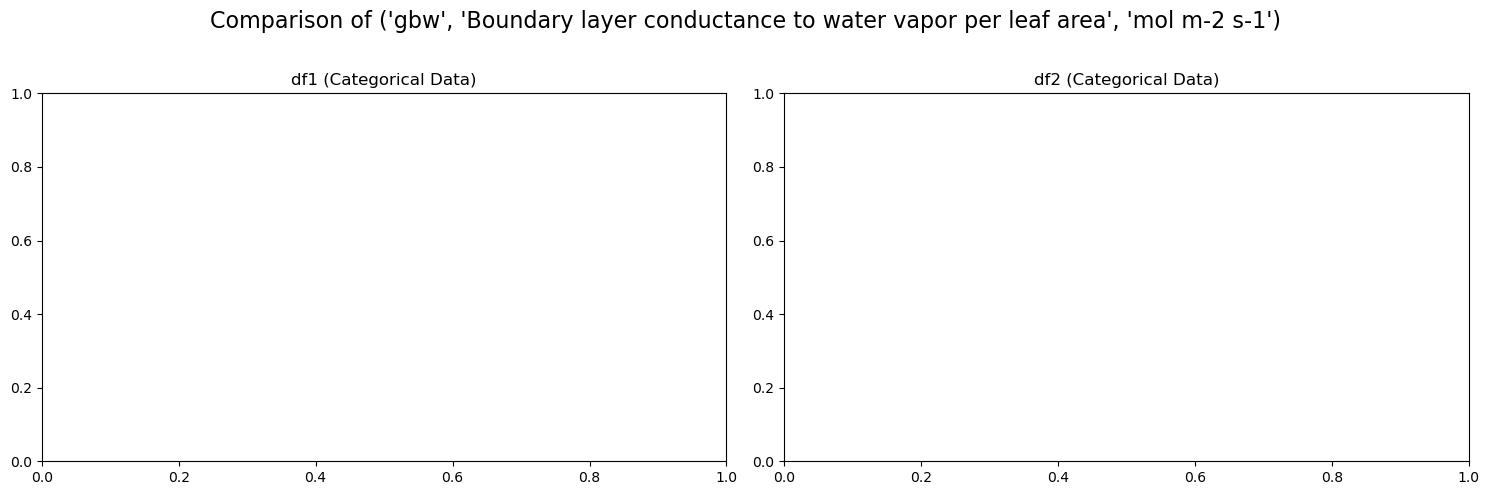

Visualizing ('CO2s', 'CO2 concentration in wet air inside chamber', 'ppm') and ('CO2s', 'CO2 concentration in wet air inside chamber', 'μmol mol-1')


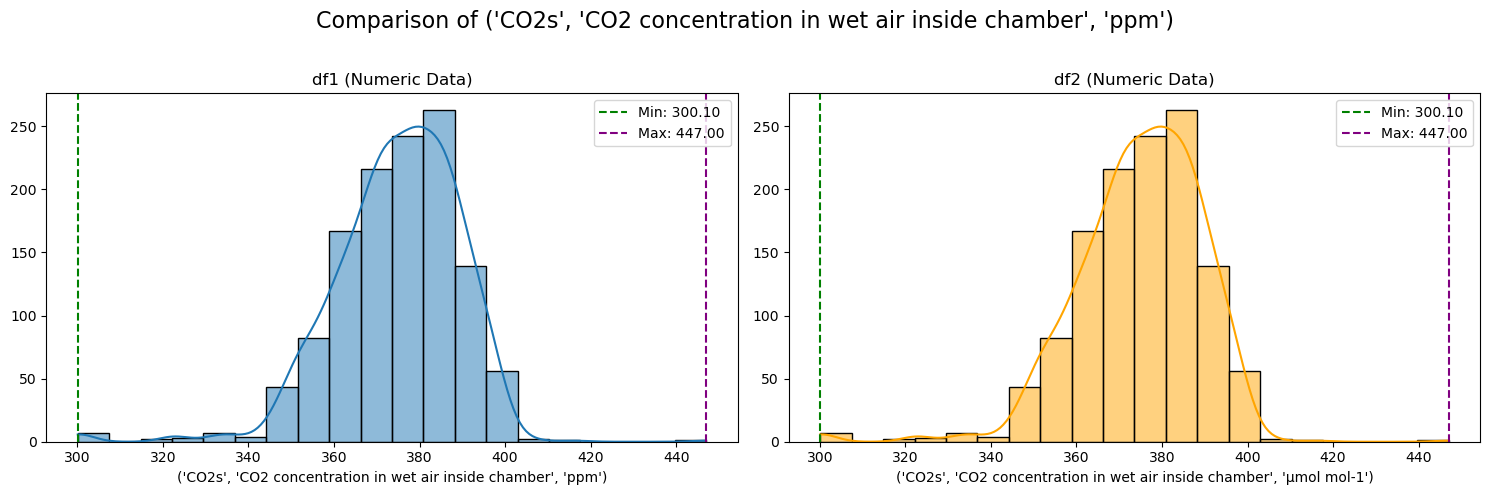

Visualizing ('Ci', 'Intercellular CO2 concentration in air', 'ppm') and ('Ci', 'Intercellular CO2 concentration in air', 'μmol mol-1')


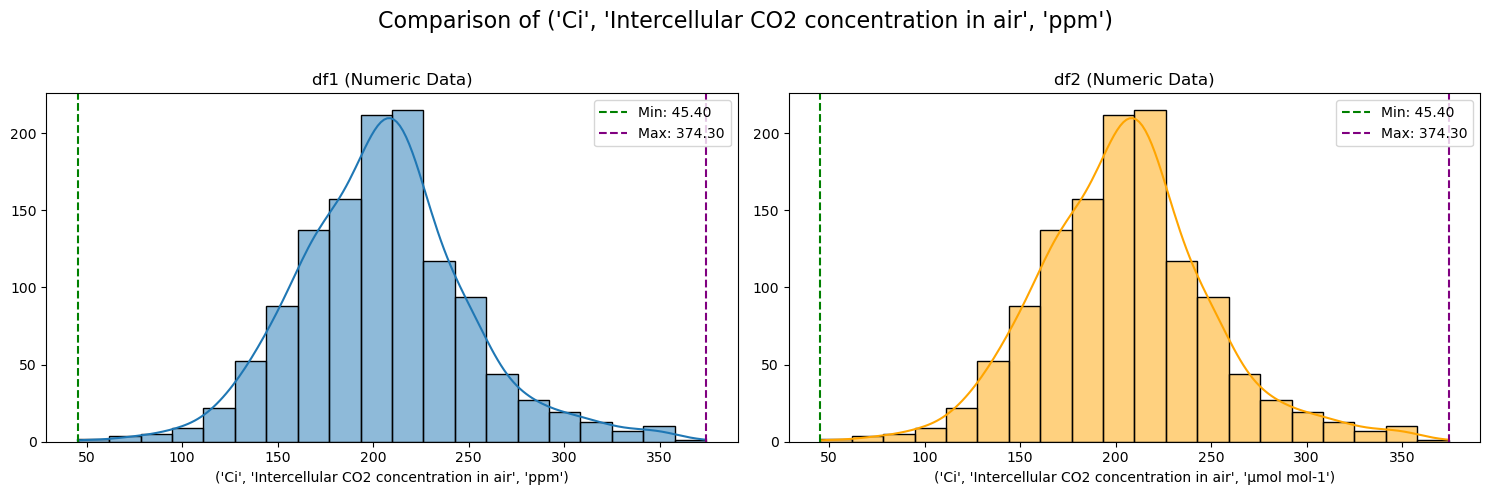

Visualizing ('gsw', 'Stomatal conductance to water vapor per leaf area', 'mol m-2 s-1') and ('gsw', 'Stomatal conductance to water vapor per leaf area', 'mmol m-2 s-1')


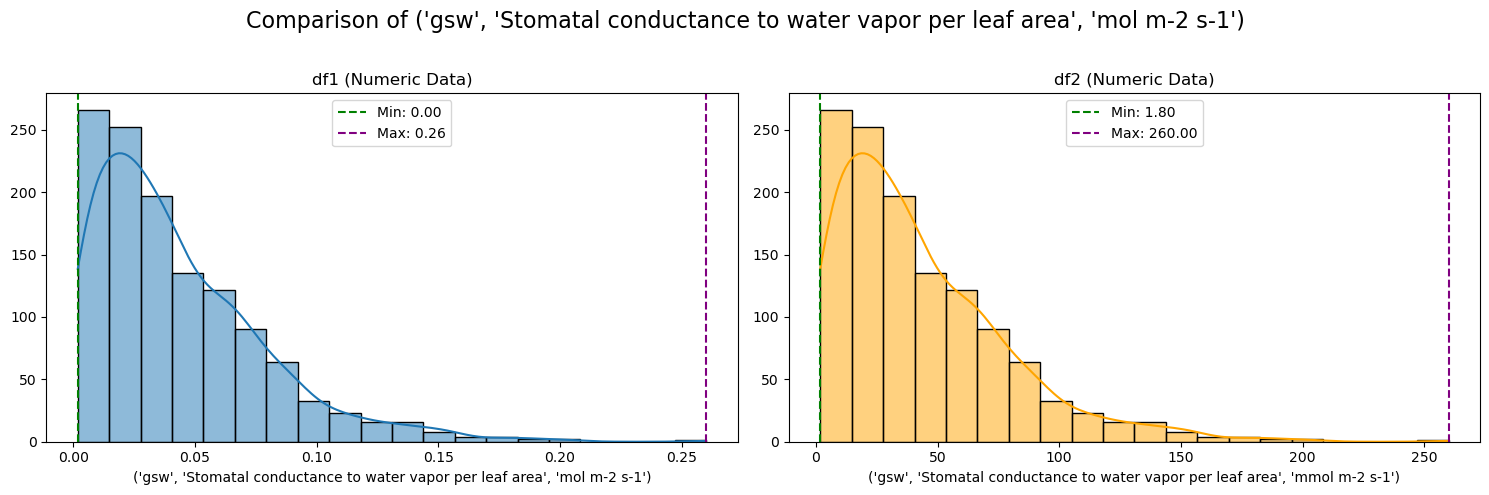

In [235]:
# Now plot the comparison
for oor_col in oor_cols:
    print(f'Visualizing {oor_col}')

    try:
        # Select columns using multi-level tuples
        selected_col_1 = merged_df_2[oor_col].squeeze()
        selected_col_2 = filtered_df[oor_col].squeeze()
        
        # Call the comparison plot function
        funcs._hist_plot_comparison(selected_col_1, selected_col_2, oor_col)

    except Exception as e:
        print('Could not plot...', e)

funcs.compare_col_hists(merged_df, preconverted_cols, merged_df_2, converted_cols)

In [236]:
# export
filtered_df.to_csv(f'../data/output/{filename}.csv', encoding='utf-8-sig')